In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
raw_data = pd.read_excel("CART Musc FIs sorted.xlsx", sheet_name=None, header=None)

In [21]:
raw_data.keys()

dict_keys(['CART BL', 'CART Post', 'Musc BL', 'Musc Post'])

In [22]:
df = raw_data["CART BL"]
df

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,Date,2014-03-01 00:00:00,NaN,2022-03-01 00:00:00,NaN,2025-03-01 00:00:00,NaN,15.04.2019,NaN,2022-04-01 00:00:00,...,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,Drug
1,Cell No,5,NaN,3,NaN,3,NaN,1,NaN,1,...,NaN,1,NaN,2,NaN,3,NaN,4,NaN,NaN
2,Rin,28.2,NaN,64.3,NaN,40.16,NaN,41.2,NaN,46.3,...,NaN,37.9,NaN,52,NaN,8.24,NaN,21.7,NaN,NaN
3,Rheo,408.25998,NaN,65.799995,NaN,267.799995,NaN,557.58,NaN,149.870002,...,NaN,358.655,NaN,64.83,NaN,932.839961,NaN,723.93498,NaN,NaN
4,Type,1,NaN,2,NaN,1,NaN,2,NaN,2,...,NaN,1,NaN,2,NaN,1,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
empty_row = df.isna().sum(axis=1).argmax()
empty_row

5

In [103]:
df1 = df.iloc[0:empty_row,:].transpose()
df1.columns = df1.iloc[0]
df1 = df1.drop(index=0).transpose()
df1

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
0,,,,,,,,,,,,,,,,,,,,,
Date,2014-03-01 00:00:00,NaN,2022-03-01 00:00:00,NaN,2025-03-01 00:00:00,NaN,15.04.2019,NaN,2022-04-01 00:00:00,NaN,...,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,2020-02-20 00:00:00,NaN,Drug
Cell No,5,NaN,3,NaN,3,NaN,1,NaN,1,NaN,...,NaN,1,NaN,2,NaN,3,NaN,4,NaN,NaN
Rin,28.2,NaN,64.3,NaN,40.16,NaN,41.2,NaN,46.3,NaN,...,NaN,37.9,NaN,52,NaN,8.24,NaN,21.7,NaN,NaN
Rheo,408.25998,NaN,65.799995,NaN,267.799995,NaN,557.58,NaN,149.870002,NaN,...,NaN,358.655,NaN,64.83,NaN,932.839961,NaN,723.93498,NaN,NaN
Type,1,NaN,2,NaN,1,NaN,2,NaN,2,NaN,...,NaN,1,NaN,2,NaN,1,NaN,1,NaN,NaN


In [86]:
df2 = df.iloc[empty_row+1:,:].reset_index(drop=True)
most_empty_rows = df2.isna().sum().max()
empty_columns = np.where(df2.isna().sum() == most_empty_rows)[0]
df2 = df2.drop(columns=empty_columns, index=0)
df2

,1,2,3,4,5,6,7,8,9,10,...,65,66,67,68,69,70,71,72,73,74
1,422.90998,6.821282,87.220002,4.666356,294.999995,3.676471,568.78,8.928572,171.58,4.604052,...,68.324995,7.990411,368.51999,10.136847,86.739998,4.565168,937.220039,22.857143,731.20998,13.755158
2,438.45002,6.439150,104.63,5.743825,304.049995,11.049724,579.85002,9.033423,190.01999,5.425936,...,77.699995,10.666667,377.60998,11.001101,105.785005,5.249344,941.739961,22.148394,738.32502,14.054813
3,451.90002,7.429420,119.570002,6.697924,318.249995,7.042253,590.44001,9.451796,205.749995,6.357279,...,87.755,9.945301,385.86501,12.113871,122.655,5.929440,946.22502,22.296543,743.85998,18.083183
4,462.78,9.199632,133.639998,7.107320,329.660005,8.764242,601.93,8.695652,219.499995,7.272727,...,98.239998,9.537435,393.31501,13.422819,137.145002,6.898931,951.170039,20.202021,749.81501,16.792612
5,472.70002,10.080646,145.620002,8.347245,340.58,9.157509,614.00002,8.278146,232.66999,7.593014,...,105.835005,13.166557,401.30002,12.523481,151.970002,6.745363,955.48,23.201857,756.58498,14.749263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def sf_ceil(x):
    return int(round(x, -int(np.floor(np.log10(abs(x))))))

NUM_BINS = 100

current = []
frequency = []
for i in range(0, len(df2.columns), 2):
    current += df2.loc[:, df2.columns[i]].tolist()
    frequency += df2.loc[:, df2.columns[i+1]].tolist()
    
max_current = sf_ceil(np.nanmax(current))
max_frequency = sf_ceil(np.nanmax(frequency))

bin_size = int(max_current / NUM_BINS)

def clean_data(data, cols, NUM_BINS):
    all_cell_data = []
    for cell_num in range(0, len(cols), 2):
        temp = data.loc[:, cols[cell_num:cell_num+2]]
        temp.columns = ["current", "frequency"]
        current_cell_data = {}
        
        for c in range(NUM_BINS):
            temp2 = temp[(temp.current >= c*bin_size) & (temp.current < (c+1)*bin_size)]
            frequency = temp2.frequency.mean()
            current_cell_data[c*bin_size] = frequency
            
        all_cell_data.append(current_cell_data)
    binned_data = pd.DataFrame(all_cell_data)
    binned_data = binned_data.fillna(0)
    
    return binned_data

binned_data = clean_data(df2, df2.columns, NUM_BINS)
binned_data

,0,30,60,90,120,150,180,210,240,270,...,2700,2730,2760,2790,2820,2850,2880,2910,2940,2970
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,4.666356,6.220875,7.727283,9.373145,10.767893,12.677630,14.204919,15.368480,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.676471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,4.604052,5.891608,7.432871,8.544206,9.400055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

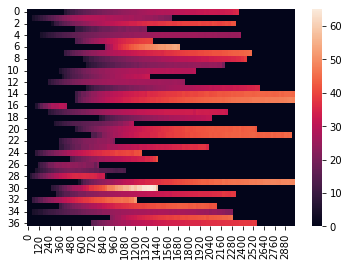

In [98]:
sns.heatmap(binned_data.transpose())

In [92]:
def justify(a, invalid_val=0, axis=1, side='left'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """

    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val) 
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

aligned_data = pd.DataFrame(justify(binned_data.values, invalid_val=0., axis=1, side='left'))
aligned_data.columns = binned_data.columns
aligned_data

,0,30,60,90,120,150,180,210,240,270,...,2700,2730,2760,2790,2820,2850,2880,2910,2940,2970
0,6.630216,8.903233,10.925471,11.396882,13.023317,14.330236,14.852272,15.976616,16.559001,17.195757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.666356,6.220875,7.727283,9.373145,10.767893,12.677630,14.204919,15.368480,16.928185,18.127023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.676471,8.952073,10.235895,13.206441,14.804406,16.246329,17.379176,18.853881,20.007850,21.239594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.928572,9.242610,9.752937,11.453671,13.217341,14.196499,15.590196,15.251788,16.260197,17.660965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.604052,5.891608,7.432871,8.544206,9.400055,10.420388,11.455484,12.141144,13.148267,13.585611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.753070,15.464478,17.127686,19.439760,20.952570,22.523003,24.080193,25.205907,26.140229,27.496508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,22.447108,25.850801,28.252658,32.454997,33.273322,35.607805,36.947051,38.560492,39.753191,41.492715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9.938729,12.066608,14.473248,15.908236,17.422584,18.490235,19.534300,20.792807,21.728609,22.686917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6.798097,8.052505,10.896074,11.127396,12.863892,13.349301,14.526964,15.464751,16.486807,16.488456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.913661,7.421283,8.897649,9.532127,10.887314,11.546601,12.553724,13.439265,14.215811,14.816699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

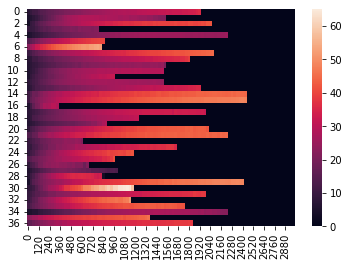

In [93]:
sns.heatmap(aligned_data)

---

In [172]:
raw_data = pd.read_csv("MN properties summary P7-10.csv", header=None)
raw_data.head(20)

data = raw_data.drop(index=raw_data.index[0:17], columns=raw_data.columns[0])
cols = data.columns
data = data.astype(float)
data

,1,2,3,4,5,6,7,8,9,10,...,235,236,237,238,239,240,241,242,243,244
17,674.41001,14.025246,757.979981,13.755158,433.57998,11.415525,672.420019,12.594459,373.980005,7.283321,...,166.385005,7.304602,340.224995,8.488964,380.844990,6.238303,361.715010,4.967710,289.469990,6.540222
18,681.95000,13.262600,765.179981,13.869625,442.78999,10.869565,680.500000,12.376238,383.660010,10.330579,...,182.349995,6.263702,350.755000,9.496676,389.675020,11.331445,383.944990,4.498425,301.669990,8.196721
19,689.27998,13.661202,772.670019,13.351135,452.92002,9.871668,687.350000,14.598540,392.779981,10.964912,...,193.505000,8.964590,369.115010,5.446623,399.230000,10.460251,400.100019,6.190034,308.674995,14.275517
20,694.85000,17.953321,778.979981,15.873015,461.30000,11.918951,693.810010,15.479877,400.779981,12.500000,...,201.719990,12.180268,378.450019,10.712373,409.965010,9.319665,413.884980,7.254262,318.769990,9.905894
21,700.33999,18.214935,785.029980,16.528925,470.57998,10.787486,700.539990,14.858841,408.610010,12.787724,...,212.555000,9.225092,387.975019,10.498688,418.400019,11.848341,425.259980,8.791209,326.769990,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


50 5000


<AxesSubplot:>

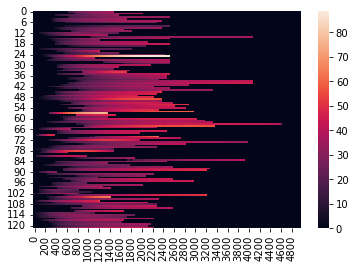

In [178]:
NUM_BINS = 100

def sf_ceil(x):
    return int(round(x, -int(np.floor(np.log10(abs(x))))))

current = []
frequency = []
for i in range(0, len(cols), 2):
    current += data.loc[:, cols[i]].tolist()
    frequency += data.loc[:, cols[i+1]].tolist()
    
max_c = sf_ceil(np.nanmax(current))
max_f = sf_ceil(np.nanmax(frequency))

bin_size = int(max_c / NUM_BINS)
print(bin_size, max_c)

all_cell_data = []

for cell_num in range(0, len(cols), 2):
    temp = data.loc[:, cols[cell_num:cell_num+2]]
    temp.columns = ["current", "frequency"]
    current_cell_data = {}
    
    for c in range(NUM_BINS):
        temp2 = temp[(temp.current >= c*bin_size) & (temp.current < (c+1)*bin_size)]
        frequency = temp2.frequency.mean()
        current_cell_data[c*bin_size] = frequency
        
    all_cell_data.append(current_cell_data)
binned_data = pd.DataFrame(all_cell_data)
binned_data = binned_data.fillna(0)

sns.heatmap(binned_data)